In [2]:
import torch
import torch.nn as nn
import torchvision

class Flatten(nn.Module):
    def __init__(self,base):
        super(Flatten, self).__init__()
        self.base = base
        pass
    def __call__(self,x): return self.base(x.reshape((x.shape[0],-1)))

class LeNet(nn.Module):
    """LeNet classification network that works on 28 by 28 by 3 images"""
    def __init__(self,num_classes):
        super(LeNet, self).__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels=3,out_channels=20,kernel_size=(5,5),stride=(1,1)),
            nn.Tanh(),
            nn.MaxPool2d(2,stride=2),
            nn.Conv2d(in_channels=20,out_channels=50,kernel_size=(5,5),stride=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            Flatten(nn.Linear(800,300)),
            nn.ReLU(),
            nn.Linear(300,num_classes),
            nn.Softmax()
        ])
    
    def forward(self, x : torch.Tensor):
        if len(x.shape)==3:
            x=x.unsqueeze(0)
        for l in self.layers:
            x = l(x)
        return x


In [3]:
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

transform = T.Compose([
    T.Resize((28,28)),
    T.ToTensor(),
    T.Normalize(0,1),
])

#download https://www.kaggle.com/datasets/prasunroy/natural-images
dataset = torchvision.datasets.ImageFolder(
    "/kaggle/input/natural-images/natural_images",
    transform=transform)

# достанем классы
targets = [label for _, label in dataset.imgs]

# разделим датасет
train_idx, test_idx = train_test_split(
    list(range(len(targets))),
    test_size=0.05,
    stratify=targets
)

# создадим даталодеры
train_data = Subset(dataset, train_idx)
test_data = Subset(dataset, test_idx)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

class 0


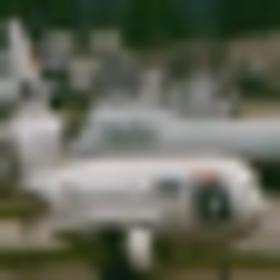

In [4]:
from random import randint

to_pil = T.functional.to_pil_image
random_index = randint(0,len(dataset)-1)
sample = dataset[random_index]
print("class",sample[1])
to_pil(sample[0]).resize((280,280))

In [5]:
# создадим модель
num_classes = 8
device = "cuda"
model = LeNet(num_classes)
model=nn.DataParallel(model).to(device)

In [6]:
import torch.nn.functional as F
from torch.optim import AdamW
from torchmetrics import Accuracy

optim = AdamW(model.parameters(),lr=0.001)
metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)
train_acc = []
test_acc = []
for epoch in range(20):
    avg_train_acc = 0
    avg_test_acc = 0
    for batch in train_loader:
        images = batch[0].to(device)
        classes = batch[1].to(device)
        pred = model.forward(images)
        loss = F.cross_entropy(pred,classes)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        pred_class = torch.argmax(pred, dim=1)
        avg_train_acc+=metric(pred_class,classes)
        
    for batch in test_loader:
        images = batch[0].to(device)
        classes = batch[1].to(device)
        with torch.no_grad():
            pred = model.forward(images)
            pred_class = torch.argmax(pred, dim=1)
            avg_test_acc+=metric(pred_class,classes)
    
    avg_train_acc/=len(train_loader)
    avg_test_acc/=len(test_loader)
    
    print(f"Epoch {epoch}\tTrain accuracy {avg_train_acc:.2f}\tTest accuracy {avg_test_acc:.2f}")
    train_acc.append(avg_train_acc)
    test_acc.append(avg_test_acc)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 0	Train accuracy 0.50	Test accuracy 0.65
Epoch 1	Train accuracy 0.71	Test accuracy 0.76
Epoch 2	Train accuracy 0.78	Test accuracy 0.80
Epoch 3	Train accuracy 0.81	Test accuracy 0.80
Epoch 4	Train accuracy 0.83	Test accuracy 0.84
Epoch 5	Train accuracy 0.85	Test accuracy 0.85
Epoch 6	Train accuracy 0.87	Test accuracy 0.85
Epoch 7	Train accuracy 0.87	Test accuracy 0.84
Epoch 8	Train accuracy 0.89	Test accuracy 0.86
Epoch 9	Train accuracy 0.90	Test accuracy 0.84
Epoch 10	Train accuracy 0.90	Test accuracy 0.86
Epoch 11	Train accuracy 0.90	Test accuracy 0.84
Epoch 12	Train accuracy 0.91	Test accuracy 0.87
Epoch 13	Train accuracy 0.92	Test accuracy 0.87
Epoch 14	Train accuracy 0.92	Test accuracy 0.85
Epoch 15	Train accuracy 0.92	Test accuracy 0.86
Epoch 16	Train accuracy 0.93	Test accuracy 0.86
Epoch 17	Train accuracy 0.94	Test accuracy 0.86
Epoch 18	Train accuracy 0.94	Test accuracy 0.87
Epoch 19	Train accuracy 0.95	Test accuracy 0.86


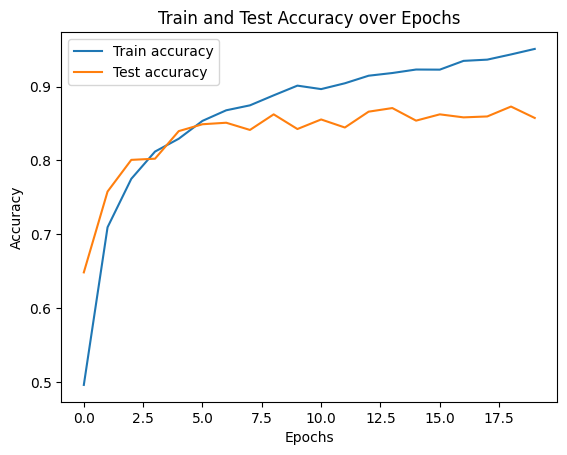

In [8]:
import matplotlib.pyplot as plt

# Plotting
plt.plot([v.cpu() for v in train_acc], label='Train accuracy')
plt.plot([v.cpu() for v in test_acc], label='Test accuracy')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over Epochs')

# Adding legend
plt.legend()

# Show plot
plt.show()